In [1]:
from detection.mtcnn            import MTCNN
from antispoofing.LivenessNet   import LivenessNet
from recognition.MobileFaceNet  import MobileFacenet
from recognition.face_recognize import recognize

from skimage import transform as trans
from matplotlib import pyplot as plt
from torchvision import transforms
from PIL import Image

import numpy as np
import torch
import cv2
import json
import os

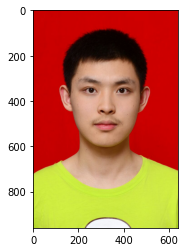

(960, 640, 3)


In [2]:
# visualize an image from official CASIA-WebFace dataset without aligning

original_image_path = 'me.jpg'

img = Image.open(original_image_path)
img_for_visualize = np.array(img)

plt.imshow(img_for_visualize)
plt.show()

print(img_for_visualize.shape)

In [3]:
# initialize device to run models, which will be referred globally. =o=
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# implement MTCNN to detect faces
# preserve PIL format from last step
mtcnn_model = MTCNN(device = device)

In [5]:
# boxes  -> List[List[float(4)]],    recording all possibile detected bounding boxes of faces
# probs  -> List[float(1)],          recording the probability corresponding to each bbox
# points -> List[numpy.array(5, 2)], recording the detected 5 keypoints location in each bbox
boxes, probs, points = mtcnn_model(img)

/home/sushang/MobileFaceNet_Pytorch-master/detection/mtcnn.py:178: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  mask_inds = mask.nonzero()


In [6]:
# just print them to have better understanding
print(boxes)
print(probs)
print(points)

[[169.63242 170.76389 480.30753 591.2861 ]]
[0.9999999]
[[[258.24597 350.7676 ]
  [396.28693 352.72647]
  [330.7948  433.63416]
  [267.41495 500.89883]
  [381.0592  503.96698]]]


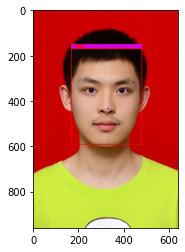

In [7]:
# visualize bbox and keypoints in original image

show_bbox      = True
show_keypoint  = True
show_prob      = True
show_prob_bg   = True
bbox_color     = (255, 0, 0)
keypoint_color = (0, 0, 255)
prob_color     = (255, 0, 0)
prob_bgcolor   = (220, 0, 220)

img = np.array(img)

# for security, make a copy
img_visual = img.copy()

boxes  = boxes.astype(np.int)
points = points.astype(np.int)

for bbox, prob, point in zip(boxes, probs, points):
    
    if show_bbox == True:
        cv2.rectangle(img_visual, (bbox[0], bbox[1]), (bbox[2], bbox[3]), bbox_color, 2)
    
    if show_keypoint == True:
        for cur_loc in point:
            cv2.circle(img_visual, tuple(cur_loc), 3, keypoint_color, -1)
    
    if show_prob == True:
        # decoration =o=
        if show_prob_bg == True:
            cv2.rectangle(img_visual, (bbox[0] - 1, bbox[1] - 20), (bbox[2] + 1, bbox[1] - 2), prob_bgcolor, -1)
        cv2.putText(img_visual, "%.4f" % prob, (bbox[0] + 5, bbox[1] - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.47, prob_color, 2)

plt.imshow(img_visual)
plt.show()

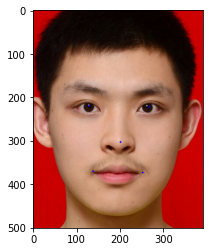

shape: (501, 391, 3)


In [8]:
# crop the bbox from original image and extract keypoint location
# you can choose to visualize new keypoint in cropped images
# [warning] If you strictly follow pad_width = pad_height = 0, the cropped face will wrap the face tightly,
#           which will infect the performance after projection, causing too much black background.
#           In fact, setting padding to a large value may not do harm to the steps later.

img = np.array(img)

pad_height         = 40
pad_width          = 40
visualize_keypoint = True
verbose            = True
keypoint_color     = (0, 0, 255)

img_crop_list      = []
point_crop_list    = []

for bbox, point in zip(boxes, points):
    img_crop_list.append(img[(bbox[1] - pad_height):(bbox[3] + pad_height),
                             (bbox[0] - pad_width) :(bbox[2] + pad_width), :].copy())
    
    point_crop = point.copy()
    point_crop[:, 0] -= (bbox[0] - pad_width)
    point_crop[:, 1] -= (bbox[1] - pad_height)
    
    point_crop_list.append(point_crop)

for img_crop, point_crop in zip(img_crop_list, point_crop_list):
    img_crop_visual = img_crop.copy()
    
    if visualize_keypoint:
        for cur_loc in point_crop:
            cv2.circle(img_crop_visual, tuple(cur_loc), 2, keypoint_color, -1)
        
    plt.imshow(img_crop_visual)
    plt.show()
    
    if verbose:
        print("shape:", img_crop_visual.shape)

In [9]:
# initialize official keypoint location
# next: project keypoint location according to this 
std_keypoint = np.array([
    [30.2946, 51.6963],
    [65.5318, 51.5014],
    [48.0252, 71.7366],
    [33.5493, 92.3655],
    [62.7299, 92.2041]
]).astype(np.int)

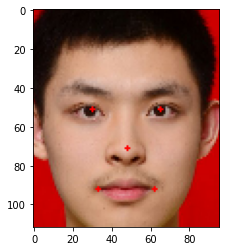

shape: (112, 96, 3)


In [10]:
img_aligned_list = []

aligned_width          = 96
aligned_height         = 112
borderValue            = 0.0
visualize_std_keypoint = True
verbose                = True
keypoint_color         = (255, 0, 0)

for img_crop, point_crop in zip(img_crop_list, point_crop_list):
    tform = trans.SimilarityTransform()
    tform.estimate(point_crop, std_keypoint)
    M = tform.params[0:2, :]
    img_aligned = cv2.warpAffine(img_crop, M, (aligned_width, aligned_height), borderValue = borderValue)
    
    img_aligned_list.append(img_aligned)

for img_aligned in img_aligned_list:
    img_aligned_visual = img_aligned.copy()
    if visualize_std_keypoint:
        for cur_loc in std_keypoint:
            cv2.circle(img_aligned_visual, tuple(cur_loc), 1, keypoint_color, -1)
    
    plt.imshow(img_aligned_visual)
    plt.show()
    
    if verbose:
        print("shape:", img_aligned_visual.shape)

In [ ]:
# compare with official aligned image to see if projection is correct
# Not necessary to run this cell, because you may not have official [aligned] dataset! 
img_test = Image.open('/home/sushang/Downloads/CASIA-WebFace-112X96/0000212/156.jpg')
img_test_visual = np.array(img_test)

for cur_loc in std_keypoint:
    cv2.circle(img_test_visual, tuple(cur_loc), 1, keypoint_color, -1)

plt.imshow(img_test_visual)
plt.show()

print(img_test_visual.shape)

In [16]:
# face antispoofing: keras -> pytorch
# Reminder: antispoofing stage can be taken without keypoint aligning
# transform operations is designed according to training requirements

antispoofing_state_dict_path = "antispoofing/LivenessNet_checkpoint.pth"

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

antispoofing_net        = LivenessNet()
antispoofing_net.eval()
antispoofing_state_dict = torch.load(antispoofing_state_dict_path)

# state_dict = {'epoch: int, 'state_dict': (real model's state dict)}
antispoofing_net.load_state_dict(antispoofing_state_dict["state_dict"])
antispoofing_net.to(device)

for img_aligned in img_aligned_list:
    img_aligned_tensor = transform(img_aligned)
    img_aligned_tensor = img_aligned_tensor.unsqueeze(0).to(device)
    
    antispoofing_result = antispoofing_net(img_aligned_tensor).item()
    print("probability: %.4f —> " % antispoofing_result, end = "")
    
    # output of model is the probability to predict the given image to be [real] face
    if antispoofing_result >= 0.5:
        print("Real face")
    else:
        print("Fake face")

probability: 1.0000 —> Real face


In [19]:
# anti-spoofing module gives correct answer.. now ready for face recognition！
# if you doesn't encode your image database into feature.json, please run 'python encode.py',
# which will encode your jpg/png images into List format and store them into json file,
# so that face recognition will be based on feature comparison

# now load MobileFacenet model

recognition_state_dict_path = "recognition/MobileFacenet_checkpoint.ckpt"
picture_name                = img_aligned_list[0] # "2017011525_5.jpg"
feature_save_dir            = "feature.json"

assert os.path.isfile(recognition_state_dict_path)

if isinstance(picture_name, str):  
    assert os.path.isfile(picture_name)
assert os.path.isfile(feature_save_dir)

recognition_net = MobileFacenet()
recognition_state_dict = torch.load(recognition_state_dict_path)
recognition_net.load_state_dict(recognition_state_dict["net_state_dict"])
recognition_net.to(device)
recognition_net.eval()

# start to recognize
recognize(picture_name, recognition_net, device, feature_save_dir)

|  name / number   |     similarity      
----------------------------------------
|  2017010924_1    |      0.212815
|  2017011525_0    |      0.618581
|  2017011525_1    |      0.637707
|  2017011525_2    |      0.555961
|  2017011525_3    |      0.628637
|  2017011525_4    |      0.617085
|  2018011489      |      0.121270
|  2018011489_10   |      -0.021752
|  2018011489_11   |      0.042151
|  2018011489_12   |      -0.083798
|  2018011489_14   |      0.082864
|  2018011489_3    |      0.106699
|  2018011489_4    |      0.047088
|  2018011489_5    |      0.071550
|  2018011489_6    |      0.013884
|  2018011489_7    |      0.013884
|  2018011489_9    |      0.115359
|  ljw0            |      0.167978
|  lwh1            |      0.078129

final decision: 2017011525_1
similarity: 0.6377


In [ ]:
# pipeline temporarily complete~